In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("../../data/stats_by_game_played.csv", low_memory=False)
data["didnt_blank"] = (data["points_scored"] > 2).astype(int)

In [5]:
data.columns

Index(['gw', 'year', 'player', 'n_games_in_gw', 'points_scored',
       'playing_against_mean_difficulty', 'playing_against_mean_defence',
       'playing_against_mean_attack', 'playing_for_difficulty',
       'playing_for_defence', 'playing_for_attack', 'form', 'position',
       'creativity', 'influence', 'threat', 'selected', 'playing_chance',
       'birth_date', 'corners_and_free_kicks_order', 'penalties_order',
       'avg_minutes_when_playing', 'avg_points_when_playing',
       'avg_yellows_p_game_when_playing', 'avg_reds_p_game_when_playing',
       'avg_bps_p_game_when_playing', 'avg_goals_p_game_when_playing',
       'avg_assists_p_game_when_playing', 'avg_clean_sheets_when_playing',
       'avg_goals_conceded_when_playing', 'avg_starts_when_playing',
       'avg_saves_when_playing', 'didnt_blank'],
      dtype='object')

In [10]:
df = data.copy().drop(columns=["year", "gw", "player", "birth_date", "points_scored"])


In [11]:
df.head()

,n_games_in_gw,playing_against_mean_difficulty,playing_against_mean_defence,playing_against_mean_attack,playing_for_difficulty,playing_for_defence,playing_for_attack,form,position,creativity,...,avg_yellows_p_game_when_playing,avg_reds_p_game_when_playing,avg_bps_p_game_when_playing,avg_goals_p_game_when_playing,avg_assists_p_game_when_playing,avg_clean_sheets_when_playing,avg_goals_conceded_when_playing,avg_starts_when_playing,avg_saves_when_playing,didnt_blank
0,1,2.0,1190.0,1170.0,4.0,1160.0,1160.0,0.00,2,97.7,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
1,1,2.0,1110.0,1090.0,2.0,1080.0,1110.0,0.25,2,97.7,...,1.00,0.0,6.0,0.0,0.0,0.0,1.00,0.0,0.0,0
2,2,2.0,1205.0,1195.0,4.0,1080.0,1110.0,0.00,2,97.7,...,0.50,0.0,4.5,0.0,0.0,0.0,0.50,0.0,0.0,1
3,1,2.0,1100.0,1130.0,2.0,1080.0,1110.0,1.00,2,97.7,...,0.25,0.0,10.0,0.0,0.0,0.0,0.75,0.0,0.0,0
4,1,2.0,1080.0,1150.0,3.0,1160.0,1160.0,1.20,2,97.7,...,0.20,0.0,10.4,0.0,0.0,0.0,0.80,0.0,0.0,1


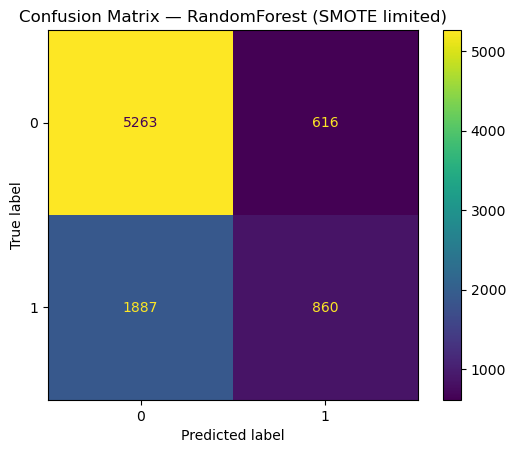

              precision    recall  f1-score   support

           0      0.736     0.895     0.808      5879
           1      0.583     0.313     0.407      2747

    accuracy                          0.710      8626
   macro avg      0.659     0.604     0.608      8626
weighted avg      0.687     0.710     0.680      8626



In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


y = df["didnt_blank"].values
X = df.drop(columns=["didnt_blank"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Train Random Forest
clf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions & evaluation
y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix — RandomForest (SMOTE limited)")
plt.show()

print(classification_report(y_test, y_pred, digits=3))


                            feature  importance
20      avg_bps_p_game_when_playing    0.066390
17          avg_points_when_playing    0.063877
10                        influence    0.063002
2      playing_against_mean_defence    0.058506
7                              form    0.056558
24  avg_goals_conceded_when_playing    0.055617
3       playing_against_mean_attack    0.054661
16         avg_minutes_when_playing    0.054182
12                         selected    0.053367
9                        creativity    0.050666
23    avg_clean_sheets_when_playing    0.048340
11                           threat    0.047111
18  avg_yellows_p_game_when_playing    0.042779
5               playing_for_defence    0.039888
6                playing_for_attack    0.038766
22  avg_assists_p_game_when_playing    0.033778
21    avg_goals_p_game_when_playing    0.029916
25          avg_starts_when_playing    0.028993
0                     n_games_in_gw    0.023563
4            playing_for_difficulty    0

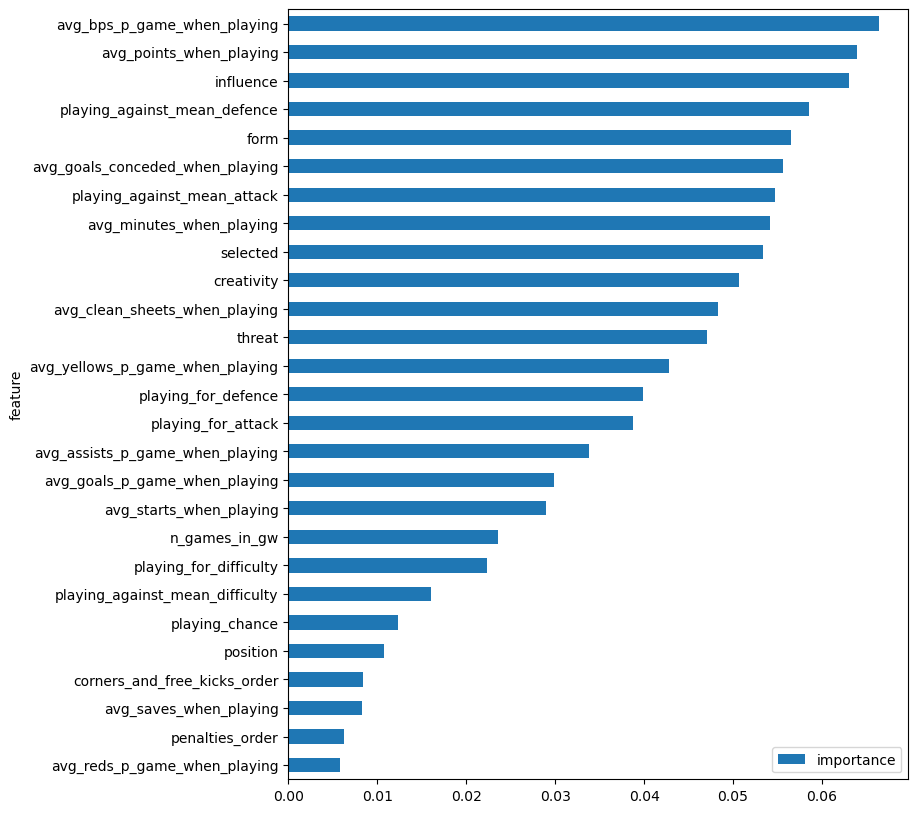

In [16]:
import pandas as pd
import numpy as np

importances = clf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df.head(20))

feat_imp_df.plot(kind="barh", x="feature", y="importance", figsize=(8, 10))
plt.gca().invert_yaxis()
plt.show()
